In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm, metrics
from sklearn.model_selection import LeaveOneGroupOut, KFold, GridSearchCV, GroupKFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.externals import joblib
from sklearn.datasets import make_regression
from scipy.stats import randint as sp_randint
from matplotlib import pyplot as plt
from collections import defaultdict

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
%matplotlib inline
import biom
import calour as ca
from scipy import stats
import scipy
import pickle
import time
import math
import inspect
import operator
pd.set_option('display.max_rows', 10000)

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


# Importing data, no TSS normalization performed here

In [3]:
allMetab = ca.read_amplicon('PMI_MS1_FeatureTable_Normalized.biom','pmi3_metab_meta.txt', min_reads=1, normalize = None)

## Remove controls and samples clustering with controls on PCoA

In [4]:
allMetab = allMetab.filter_samples('control', 'n')
allMetab = allMetab.filter_samples('pcoa_removals', 'n')
allMetab.sample_metadata.description.value_counts()

skin.hip    746
soil.hip    744
Name: description, dtype: int64

In [5]:
print("Number of samples: ",len(allMetab.sample_metadata.metab_barcode.value_counts()))

Number of samples:  1490


In [6]:
print("Number of bodies: ",len(allMetab.sample_metadata.subjectID.value_counts()))

Number of bodies:  36


# General Model of All Facilites, Samples, and Season using ADD 0C as Response and Adding Metadata to Determine Metadata Importance

In [7]:
allMetab = allMetab.add_sample_metadata_as_features(['facility','sample_type','avg_percent_humidity','total_precipitation_cm'])
print("Number of features: ",len(allMetab.feature_metadata))

Number of features:  4411


In [8]:
# designate data
X = allMetab.data
y = allMetab.sample_metadata['add_0c']
y = (y.astype(float))

# group by body
groups = allMetab.sample_metadata['subjectID']

In [9]:
# outer_cv creates 36 folds by leave-one-body-out for estimating generalization error
outer_cv = LeaveOneGroupOut().split(X, y, groups=groups)

# prints the number of folds in the outer loop
print("Number of outer folds to perform: ", LeaveOneGroupOut().get_n_splits(X, y, groups=groups))

# hyperparameter grid to test
#param_grid = {"max_depth": [None, 4],
#              "max_features": ['auto', 0.2],
#              "bootstrap": [True, False]}

param_grid = {"max_depth": [4],
              "max_features": [0.1],
              "bootstrap": [False]}

# creates loop iteration counter and empty lists for storage
count=1
model_parameters = []
nested_cv_scores = []

# loops through the sets of training and test ids in the outer loop
# the number of loops will match the number of folds as each fold is used
for train_ids, test_ids in outer_cv:
    # inner_cv creates 35 folds by leave-one-body-out for hyperparamter tuning
    # uses only the train ids present in the current outer loop fold which is one less body since the outer loop
    # folds are also using leave-one-body-out
    inner_cv = LeaveOneGroupOut().split(X[train_ids, :], y.iloc[train_ids], groups=groups[train_ids])
    # setting rf parameters
    rf = RandomForestRegressor(n_estimators=1, random_state=999, criterion='mae')
    # grid search cv using rf and the hyperparameter grid on the inner_cv training set
    rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=inner_cv, n_jobs=-1, scoring='neg_mean_absolute_error')
    # fit the grid search model on the inner_cv training set, which will tell us the best
    # parameters chosen by that inner cv
    rf_grid.fit(X[train_ids, :], y.iloc[train_ids])
    # converts best params dict to string to save it
    res = ",".join(("{}={}".format(*i) for i in rf_grid.best_params_.items()))
    # attaches each loops best params
    model_parameters.append(res)
    # prints outer fold number the loop is currently on
    print("Outer fold:",count)
    # prints number of inner folds in the outer loop (should be the same each time at 35)
    print("Number of inner folds:",LeaveOneGroupOut().get_n_splits(X[train_ids, :], y.iloc[train_ids], groups=groups[train_ids]))
    # prints best param and CV score from this inner loop set 
    print("Best params:",rf_grid.best_params_)
    print("Best CV score (MAE):",-rf_grid.best_score_)
    # uses the best model created from the inner loop to predict the outer loop body left out
    yhat = rf_grid.predict(X[test_ids,:])
    MAE = mean_absolute_error(y.iloc[test_ids], yhat)
    print("Prediction score (MAE):",MAE)
    nested_cv_scores.append(MAE)
    print("*****")
    count+=1
# prints the mean of the nested cv score (generalization error) of the models
print("\nNested CV score (generalization error): " + str(np.mean(nested_cv_scores)))

Number of outer folds to perform:  36
Outer fold: 1
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 84.24143462493676
Prediction score (MAE): 25.352845535121954
*****
Outer fold: 2
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 84.96729326886322
Prediction score (MAE): 80.48414634634145
*****
Outer fold: 3
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 81.21542910673297
Prediction score (MAE): 87.50701058190475
*****
Outer fold: 4
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 87.76751473651835
Prediction score (MAE): 71.25661375690477
*****
Outer fold: 5
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 82.3776617706423
Prediction score (MA

In [10]:
# define function to merge 2 lists as paired tuples    
def merge(list1, list2): 
    merged_list = tuple(zip(list1, list2))  
    return merged_list 

# merge parameters to nested scores as tuples
merged_list = merge(model_parameters, nested_cv_scores)

# puts the paired tuple list into a dictionary
params_and_scores = defaultdict(list)
for k, v in merged_list:
    params_and_scores[k].append(v)

In [11]:
# prints dict of params and scores, should see each set of parameters chosen and their scores
params_and_scores

defaultdict(list,
            {'bootstrap=False,max_depth=4,max_features=0.1': [25.352845535121954,
              80.48414634634145,
              87.50701058190475,
              71.25661375690477,
              159.25859787380952,
              127.34748676309525,
              99.2444444452381,
              98.64375,
              98.5857142804762,
              81.75623306195122,
              84.43108465476192,
              69.9390243902439,
              37.32296747804878,
              54.29761904438095,
              56.36177248261905,
              68.0526454997619,
              79.88231707317074,
              77.38650793571428,
              63.738359791190476,
              80.04932249268292,
              73.93809524047619,
              137.48571428571427,
              168.58022875852942,
              72.76825397142858,
              67.15079364380952,
              72.3374999954762,
              78.42195767464285,
              90.00555555428572,
              58.7

In [12]:
# create a dict to assign the mean score to each param set
avgDict = {}
for k,v in params_and_scores.items():
    avgDict[k] = sum(v)/ float(len(v))
print(avgDict)

{'bootstrap=False,max_depth=4,max_features=0.1': 86.72395129753203}


In [13]:
# prints the param set with the best mean error
print("Best params:",max(avgDict, key=avgDict.get))
print("Best mean score:",-max(avgDict.values()))

Best params: bootstrap=False,max_depth=4,max_features=0.1
Best mean score: -86.72395129753203


In [14]:
# input the best parameter set
best_model_params = {"max_depth": [4],
              "max_features": [0.1],
              "bootstrap": [False]}

# now we refit this best model on the whole dataset so that we can start
# making predictions on other data, and now we have a reliable estimate of
# this model's generalization error and we are confident this is the best model
# among the ones we have tried
final_regressor = GridSearchCV(rf, best_model_params, cv=LeaveOneGroupOut().split(X, y, groups=groups), scoring='neg_mean_absolute_error', n_jobs=-1)
final_regressor.fit(X, y)
print("Best CV score:",final_regressor.best_score_)

Best CV score: -86.72395129753201


In [15]:
joblib.dump(final_regressor.best_estimator_, 'models/PMI3_allMetab_meta_general.pkl')

['models/PMI3_allMetab_meta_general.pkl']

In [1]:
model_PMI3_allMetab_meta_general = joblib.load('models/PMI3_allMetab_meta_general.pkl')

NameError: name 'joblib' is not defined

In [17]:
model_PMI3_allMetab_meta_general

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=4, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=999, verbose=0, warm_start=False)

### Determine important features

In [18]:
importances = model_PMI3_allMetab_meta_general.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_PMI3_allMetab_meta_general.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = allMetab.feature_metadata
np.savetxt("feature_metadata/general_all_feature_metadata_meta.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
general_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    general_importances += (allMetab.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(allMetab.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X565.517636027714_7.72472345775013	0.49285613375874915
2. X228.23079588292_6.35603299435028	0.16890521873345143
3. season=summer	0.06575779785076023
4. X313.236401092986_5.28683901830283	0.06409793577600781
5. X533.380648295084_8.47133075396825	0.043938404125616316
6. X314.267826427112_6.76680303030302	0.043375911769403606
7. X195.098852603876_3.7230375449964	0.03193477458945874
8. X215.131461096591_5.04396530054644	0.023751968607241217
9. X534.232515207926_5.82127157407407	0.017572730518510892
10. X187.132559969724_3.54547162954278	0.013063191618185385
11. X661.36953050263_5.93033758503401	0.011600071488517157
12. X358.328017739688_4.93189656862745	0.010357397165445167
13. X288.180758851947_3.39794949494949	0.008232347029935957
14. X527.391812133789_7.85676263888889	0.0026538830224127254
15. X185.080538403724_2.17167016298633	0.0019022339463043755
16. X341.304059024148_7.978558685446	0.0
17. X589.444448171568_6.04995468319559	0.0
18. X440.364168590969_7.2040

In [19]:
print("Number of features present:", int(len(general_importances)/2))
general_importances_df = pd.DataFrame(np.array(general_importances).reshape(int(len(general_importances)/2),2))

np.savetxt("importances/general_all_importances_meta.csv", general_importances_df, delimiter=",", fmt='%s')

Number of features present: 4411


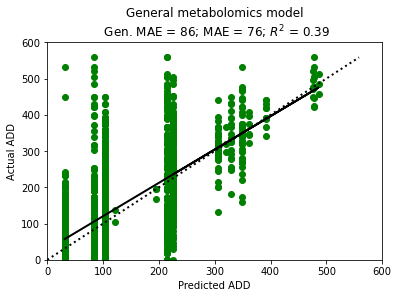

In [20]:
yhat = model_PMI3_allMetab_meta_general.predict(X)
MAE = mean_absolute_error(y, yhat)

plt.scatter(yhat, y, color = 'lightgray', edgecolors = 'k')
lower = np.min(np.concatenate([y, yhat]))
upper = np.max(np.concatenate([y, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('General metabolomics model\n Gen. MAE = %d; MAE = %d; $R^2$ = %.2f' %(np.mean(nested_cv_scores),MAE,round(model_PMI3_allMetab_meta_general.score(X,y),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/general_all_model.png')